In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [11]:
import pickle
from tqdm import trange, tqdm
import numpy as np
from train_utils import generate_doc_pairs_no_chunking
from collections import defaultdict
import re
import tikzplotlib
import matplotlib.pyplot as plt
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore")

In [21]:
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [4]:
PREPROCESSED_DATA_PATH = '../temp_data/reddit/preprocessed/'
COMPUTED_DATA_PATH = '../temp_data/reddit/preprocessed/'
FIGURES_PATH = '../figures/'

In [6]:
with open(COMPUTED_DATA_PATH + 'training_meta_data_no_chunking_bots_removed.p', 'rb') as f:
    (author_to_doc_idx, author_to_doc_idx_test, author_subreddit, author_subreddit_test, x_shape, x_shape_test) = pickle.load(f)

with open(COMPUTED_DATA_PATH + 'model_no_chunking_bots_removed.p', 'rb') as f:
    (clf, transformer, scaler, secondary_scaler, _) = pickle.load(f)

XX_train = np.memmap(COMPUTED_DATA_PATH + 'XX_train_no_chunking_bots_removed.npy', dtype='float32', mode='r', shape=x_shape)
XX_test = np.memmap(COMPUTED_DATA_PATH + 'XX_test_no_chunking_bots_removed.npy', dtype='float32', mode='r', shape=x_shape_test)

In [19]:
fnames = np.array(transformer.get_feature_names())

In [13]:
author_mapping_train = defaultdict(set)
author_to_root_train = {}
for y in author_to_doc_idx.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping_train[u].add(y)
    author_to_root_train[y] = u

subreddit_to_author_train = defaultdict(list)
for k, v in author_subreddit.items():
    subreddit_to_author_train[v].append(k)

X_idxs_train, Y_train = generate_doc_pairs_no_chunking(author_mapping_train, subreddit_to_author_train, author_to_root_train, author_to_doc_idx, author_subreddit)


new2



94253 84429 76740
94253 28275 65977


In [12]:
author_mapping_test = defaultdict(set)
author_to_root_test = {}
for y in author_to_doc_idx_test.keys():
    u = re.search(r'(.*)_[A-Z]+$', y).group(1)
    author_mapping_test[u].add(y)
    author_to_root_test[y] = u

subreddit_to_author_test = defaultdict(list)
for k, v in author_subreddit_test.items():
    subreddit_to_author_test[v].append(k)

X_idxs_test, Y_test = generate_doc_pairs_no_chunking(author_mapping_test, subreddit_to_author_test, author_to_root_test, author_to_doc_idx_test, author_subreddit_test)


new2



46924 43581 37390
46924 14077 32846


In [23]:
sampled_idxs = X_idxs_train[:50000]
explainer = shap.LinearExplainer(clf, secondary_scaler.transform(np.abs(XX_train[sampled_idxs[:, 0], :] - XX_train[sampled_idxs[:, 1], :])))

sampled_idxs = X_idxs_test[:50000]
XX_test_sampled = secondary_scaler.transform(np.abs(XX_test[sampled_idxs[:, 0], :] - XX_test[sampled_idxs[:, 1], :]))
shap_values = explainer.shap_values(XX_test_sampled)

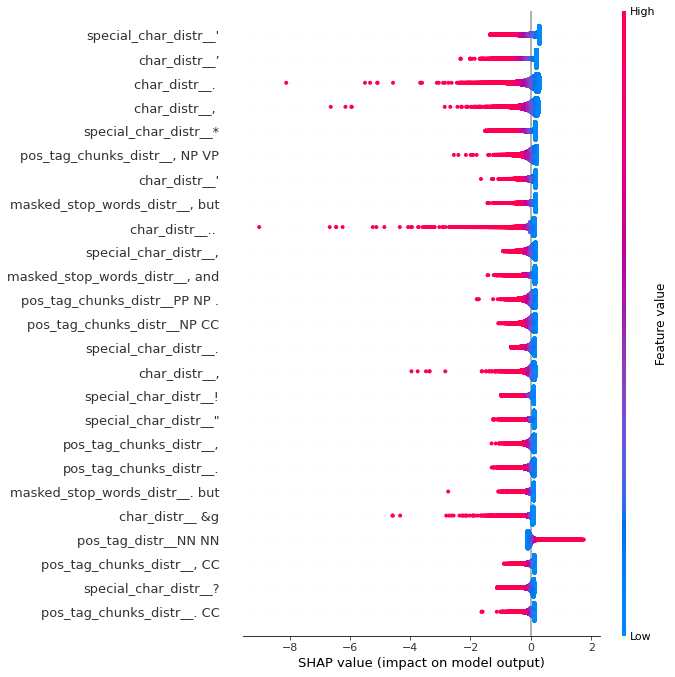

In [24]:
plt.clf()
shap.summary_plot(shap_values, XX_test_sampled, feature_names=transformer.get_feature_names(), max_display=25)
plt.tight_layout()

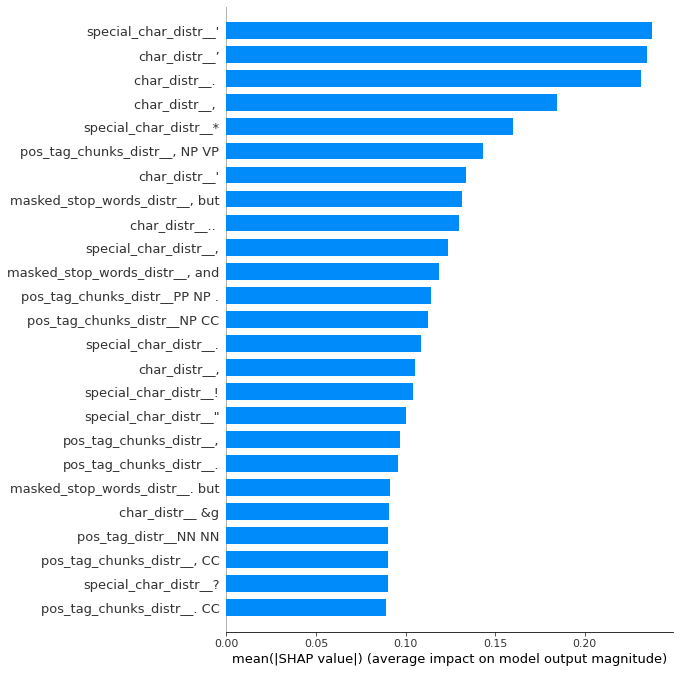

In [25]:
plt.clf()
shap.summary_plot(shap_values, XX_test_sampled, feature_names=transformer.get_feature_names(), max_display=25, plot_type="bar")
plt.tight_layout()

In [28]:
shap_means = np.abs(shap_values).mean(axis=0)
order = np.argsort(-np.abs(shap_means))
for i in range(25):
    print('{:.3f}'.format(round(shap_means[order[i]], 3)), fnames[order[i]])

0.237 special_char_distr__'
0.235 char_distr__’
0.231 char_distr__. 
0.185 char_distr__, 
0.160 special_char_distr__*
0.143 pos_tag_chunks_distr__, NP VP
0.134 char_distr__'
0.132 masked_stop_words_distr__, but
0.130 char_distr__.. 
0.124 special_char_distr__,
0.119 masked_stop_words_distr__, and
0.114 pos_tag_chunks_distr__PP NP .
0.113 pos_tag_chunks_distr__NP CC
0.109 special_char_distr__.
0.105 char_distr__,
0.104 special_char_distr__!
0.100 special_char_distr__"
0.097 pos_tag_chunks_distr__,
0.096 pos_tag_chunks_distr__.
0.091 masked_stop_words_distr__. but
0.090 char_distr__ &g
0.090 pos_tag_distr__NN NN
0.090 pos_tag_chunks_distr__, CC
0.090 special_char_distr__?
0.089 pos_tag_chunks_distr__. CC


In [27]:
featureset_bounds = {}
i = 0
for k, t in transformer.transformer_list:
    featureset_bounds[k] = (i, i + len(t.get_feature_names()))
    i += len(t.get_feature_names())
    
featuresets = np.array(list(featureset_bounds.keys()))
featureset_shap_means = np.array([shap_means[featureset_bounds[k][0]:featureset_bounds[k][1]].mean() for k in featuresets])

fig = go.Figure()
for i in np.argsort(-featureset_shap_means):
    k = featuresets[i]
    fig.add_trace(go.Violin(
        x = shap_means[featureset_bounds[k][0]:featureset_bounds[k][1]],
        text = fnames[featureset_bounds[k][0]:featureset_bounds[k][1]],
        name = k
    ))
fig.show()